# An Introduction to HyperSpy: 
## The multi-dimensional data analysis toolbox

## *"Unsupervised Learning and EDS Analysis"*

#### Joshua Taillon - *June 5, 2019*

*Note: This notebook is heavily based off the ["TEM EDS Nanoparticles"](https://nbviewer.jupyter.org/github/hyperspy/hyperspy-demos/blob/master/electron_microscopy/EDS/TEM_EDS_nanoparticles.ipynb) notebook from the [HyperSpy Demos](https://github.com/hyperspy/hyperspy-demos) repository*

## Authors:

| Date       | Author(s)            | Notes                                                      |
|:-----------|:---------------------|:-----------------------------------------------------------|
| 13/04/2015 | Pierre Burdet        | Developed for HyperSpy workshop at University of Cambridge |
| 29/05/2016 | Duncan Johnstone     | Update the syntax for HyperSpy 0.8.5 (Python 3 compatibility) |
| 03/08/2016 | Francisco de la Peña | Update the syntax for HyperSpy 1.1 |
| 06/08/2016 | Francisco de la Peña | Update the syntax for HyperSpy 0.8.1 |
| 27/08/2016 | Pierre Burdet        | Update for workshop at EMC Lyon |
| 04/04/2018 | Joshua Taillon       | Bugfix and update for workshop at NIST |
| 09/05/2019 | Joshua Taillon <br/> Andrew Herzing  |  Further updates for NIST Tutorial |

# EDS-TEM quantification of core shell nanoparticles

* Using machine learning methods, the composition of embedded nanostructures can be accurately measured 
* Demonstrated by D. Roussow et al., Nano Letters, 2015 
    * See the [full article](https://www.repository.cam.ac.uk/bitstream/handle/1810/248102/Roussouw%20et%20al%202015%20Nano%20Letters.pdf?sequence=1) for details 
* Using the same data, this notebook reproduces the main results of that article

* Requires HyperSpy v1.3+

## <a id='top'></a> Contents

1. <a href='#dat'> Specimen & Data</a>
2. <a href='#loa'> Loading</a>
3. <a href='#bss'> Blind source separation of core/shell nanoparticles</a>
4. <a href='#bare'> Representative spectrum from bare cores</a>
5. <a href='#com'> Comparison and quantification</a>
6. <a href='#fur'> Going father: Isolating the nanoparticles</a>

# <a id='dat'></a> 1. Specimen & Data

The sample and the data used in this tutorial are described in 
D. Roussow, et al., Nano Letters, In Press (2015) (see the [full article](https://www.repository.cam.ac.uk/bitstream/handle/1810/248102/Roussouw%20et%20al%202015%20Nano%20Letters.pdf?sequence=1)).

FePt@Fe$_\mathsf{3}$O$_\mathsf{4}$ core-shell nanoparticles are investigated with an EDS/TEM experiment (FEI Osiris TEM, 4 EDS detectors). The composition of the core can be measured with ICA (see figure 1c). To prove the accuracy of the results, measurements on bare FePt bimetallic nanoparticles from a synthesis prior to the shell addition step are used.

<center><img src="img/core_shell.png" style="height:550px;"></center>

###### **Figure 1:** (a) A spectrum image obtained from a cluster of core-shell nanoparticles. (b) The nanoparticles are comprised of a bi-metallic Pt/Fe core surrounded by an iron oxide shell on a carbon support. (c) ICA decomposes the mixed EDX signals into components representing the core (IC#0), shell (IC#1) and support (IC#2).

# <a id='loa'></a> 2. Loading the data

<a href='#top'> Table of contents</a>

Import HyperSpy, numpy and matplotlib libraries

In [1]:
%matplotlib notebook
import hyperspy.api as hs
import numpy as np

Load the spectrum images of the bare seeds and the core shell nanoparticles.

In [2]:
c = hs.load('data/bare_core.hdf5')
cs = hs.load('data/core_shell.hdf5')

In [3]:
# Examine the metadata of the cores:
c.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── EDS
│       │       ├── azimuth_angle = 0.0
│       │       ├── elevation_angle = 35.0
│       │       └── energy_resolution_MnKa = 130.0
│       ├── Stage
│       │   └── tilt_alpha = 0.0
│       ├── acquisition_mode = STEM
│       ├── beam_energy = 200.0
│       └── microscope = Microscope TecnaiOsiris 200 kV D658 AnalyticalTwin
├── General
│   ├── date = 14.10.2014
│   └── title = Bare core
├── Sample
│   ├── elements = array(['Fe', 'Pt'], dtype='<U2')
│   └── xray_lines = array(['Fe_Ka', 'Pt_La'], dtype='<U5')
└── Signal
    ├── binned = True
    ├── signal_origin = 
    └── signal_type = EDS_TEM

Plot the core-shell data to inspect the signal level:

<IPython.core.display.Javascript object>


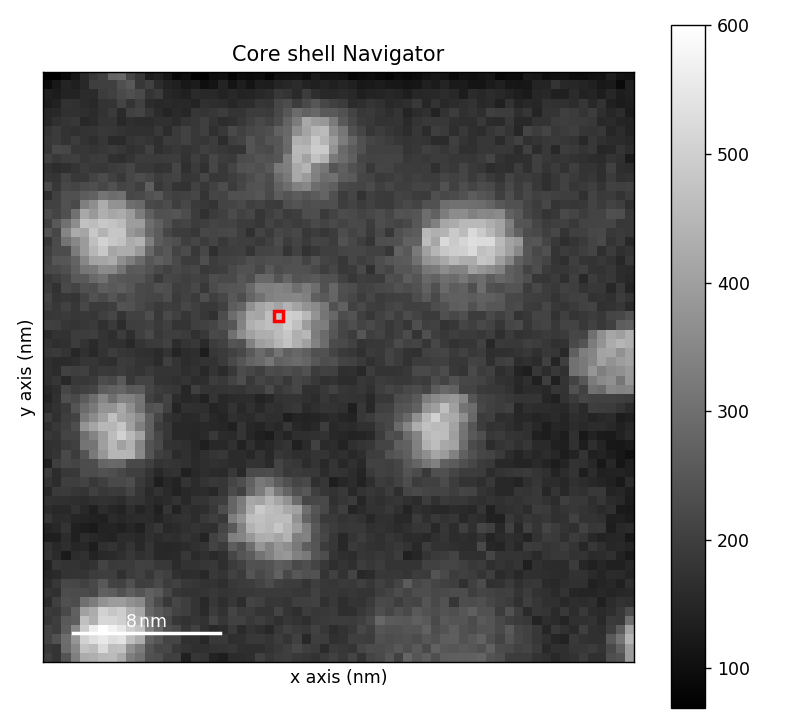

<IPython.core.display.Javascript object>


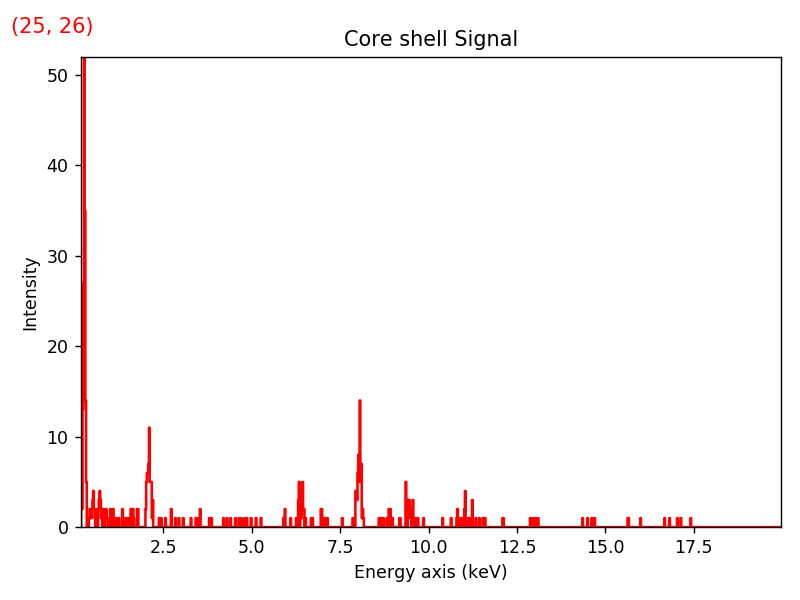

In [4]:
cs.plot()

Plot the intensity of Fe K${\alpha}$ and Pt L${\alpha}$ lines:

<IPython.core.display.Javascript object>


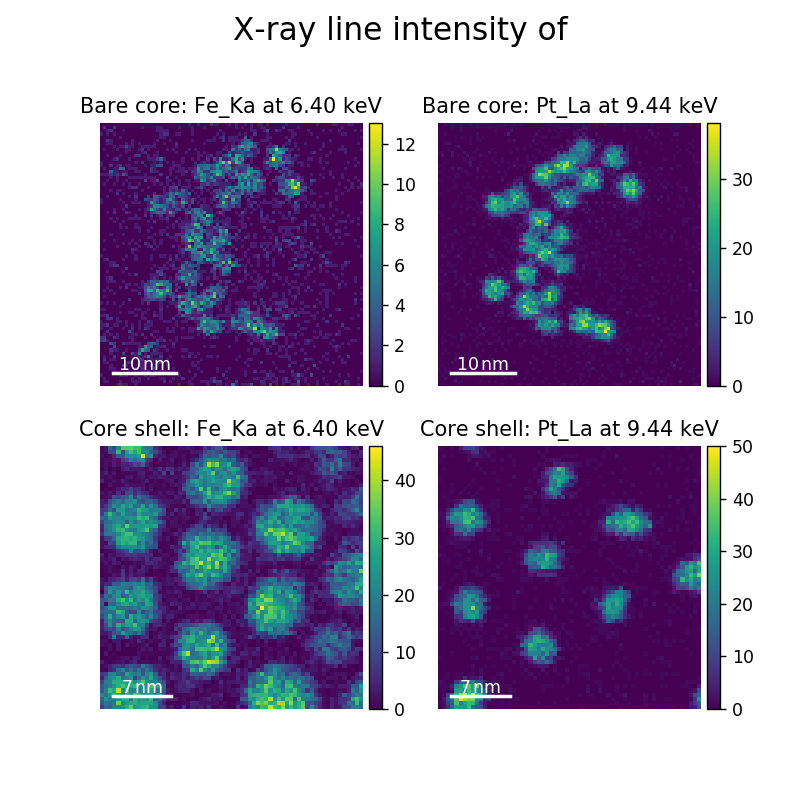

In [5]:
axes = hs.plot.plot_images(hs.transpose(*(c.get_lines_intensity() + cs.get_lines_intensity())),
                           scalebar='all', axes_decor='off', per_row=2, cmap='viridis')

## <a id='bss'></a> 3. Blind source separation of core/shell nanoparticles

<a href='#top'> Table of contents</a>

Apply blind source separation (ICA) to obtain a factor (spectrum) corresponding to the core.

In [6]:
# Have to change datatype to float for decomposition:
cs.change_dtype('float')
cs.decomposition()

<IPython.core.display.Javascript object>


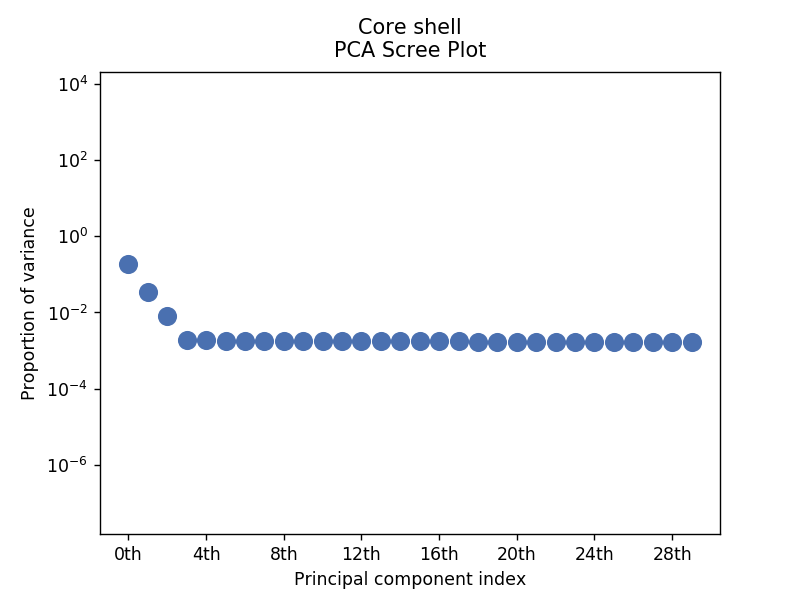

In [7]:
ax = cs.plot_explained_variance_ratio()

ICA on the three first components.

In [8]:
cs.blind_source_separation(3)

<IPython.core.display.Javascript object>


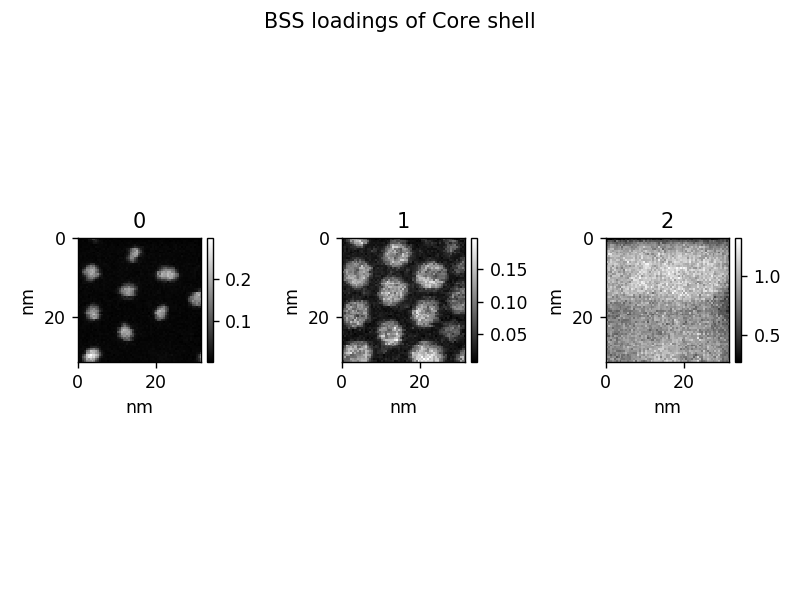

In [9]:
_ = cs.plot_bss_loadings()

<IPython.core.display.Javascript object>


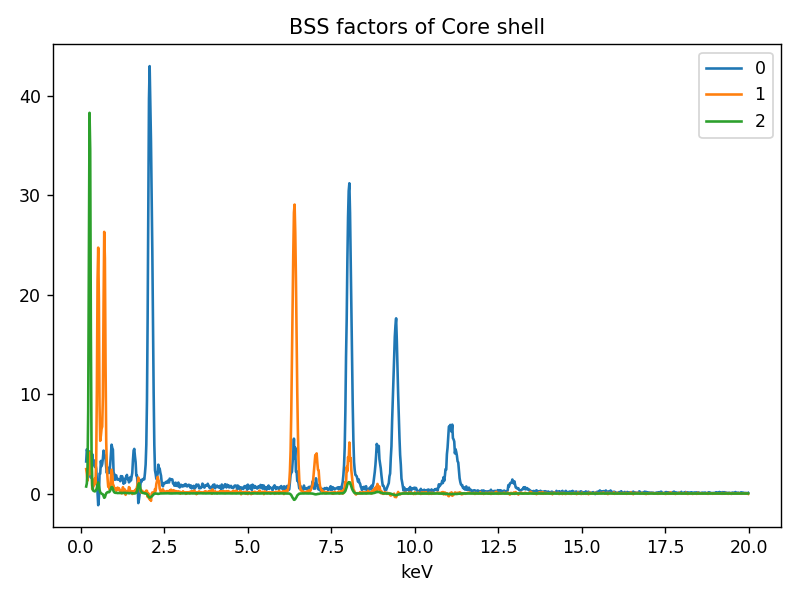

In [13]:
_ = cs.plot_bss_factors()

The first component corresponds to the core.

In [10]:
s_bss = cs.get_bss_factors().inav[0]

<IPython.core.display.Javascript object>


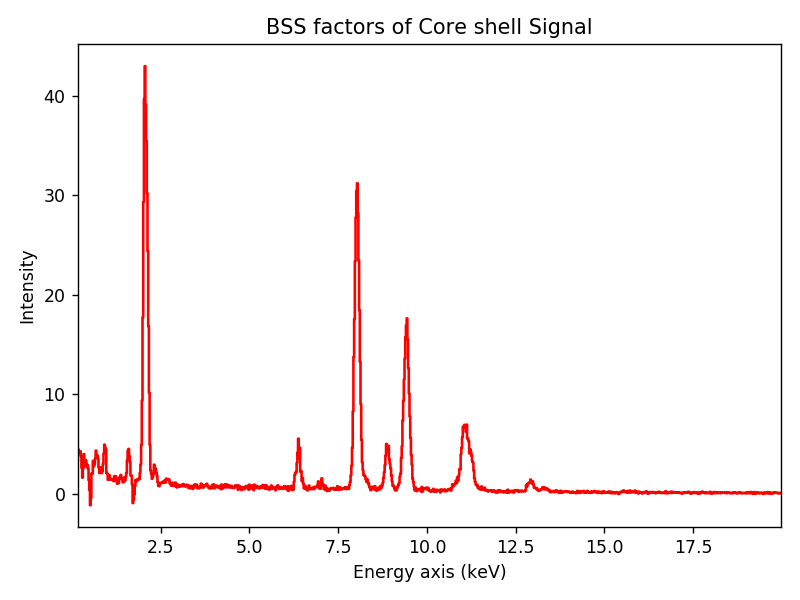

In [11]:
s_bss.plot()

## <a id='bare'></a> 4. Representative spectrum from bare cores

<a href='#top'> Table of contents</a>

We meed to obtain a representative spectrum of the bare nanoparticles
so we can compare to the BSS component

We can mask the low intensity of the Pt L${\alpha}$ signal:

In [12]:
pt_la = c.get_lines_intensity(['Pt_La'])[0]
mask = pt_la > 6

Visualizing the mask:

<IPython.core.display.Javascript object>


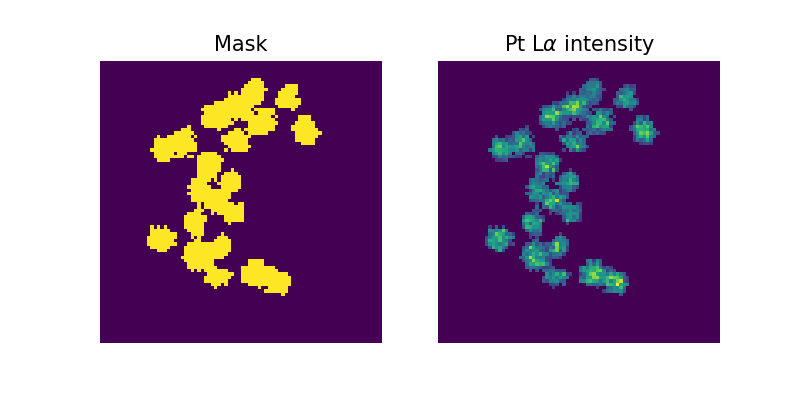

In [13]:
axes = hs.plot.plot_images(hs.transpose(*(mask, pt_la * mask)), axes_decor='off', colorbar=None,
                           label=['Mask', 'Pt L${\\alpha}$ intensity'], cmap='viridis')

Applying the mask:

* `mask` is a `Signal` containing boolean values, but it is 2D, not 3D:

In [16]:
print(mask.data.shape)
mask.data[40:45,40:45]

(84, 84)


array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False,  True,  True, False, False],
       [ True,  True,  True, False, False],
       [ True,  True,  True, False, False]])

* To apply the mask, we can just multiply the signals together thanks to `numpy`'s array broadcasting:

In [17]:
c_masked = c * mask

<IPython.core.display.Javascript object>


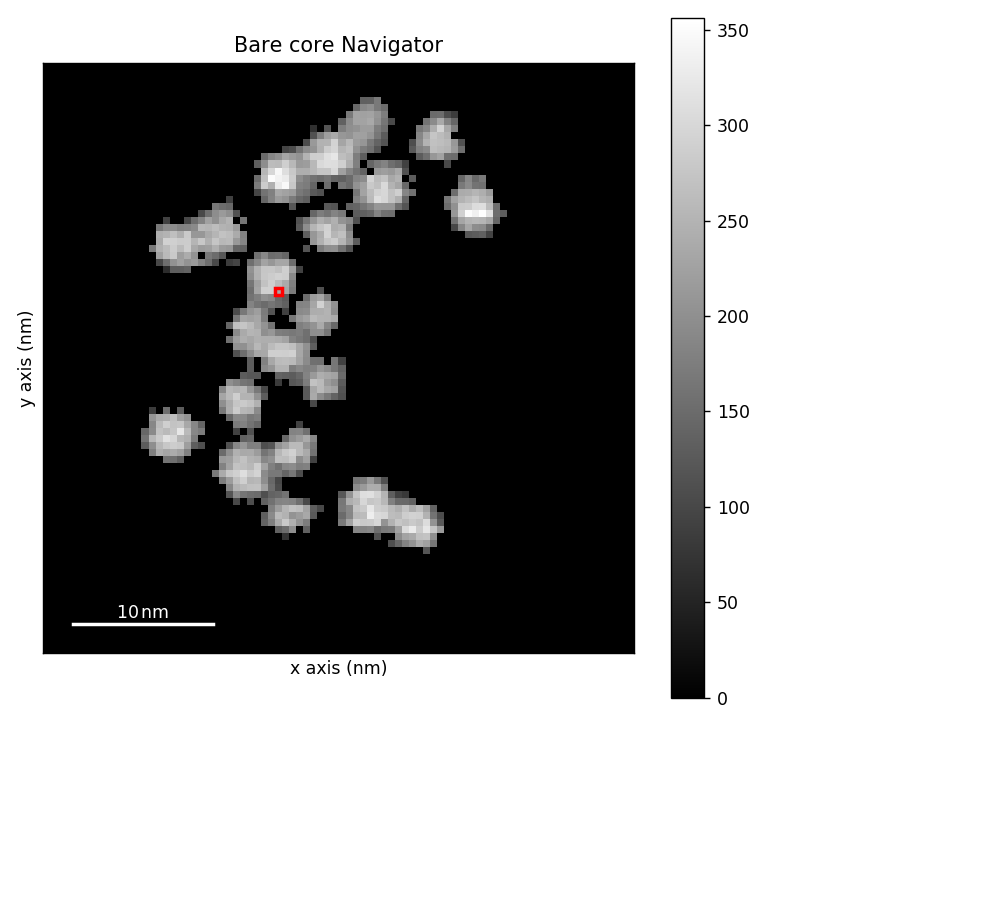

<IPython.core.display.Javascript object>


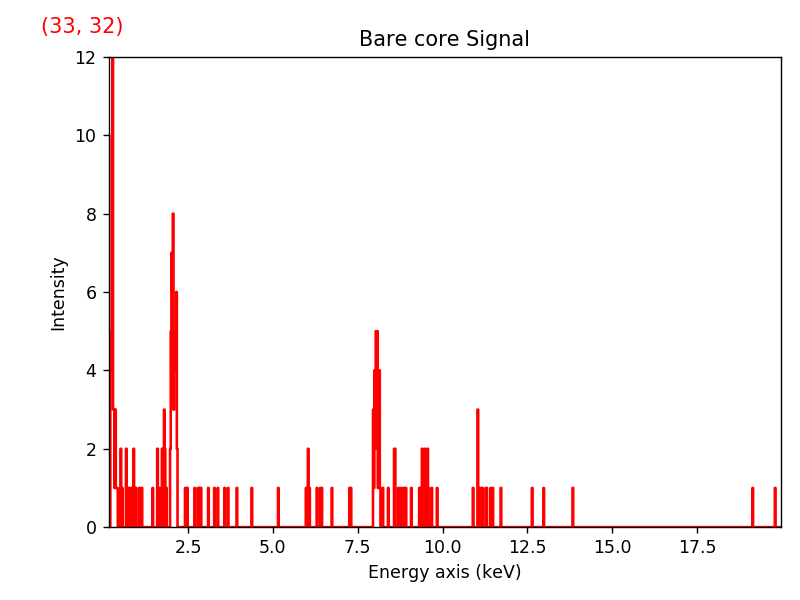

In [18]:
c_masked.plot()

The sum over the masked particles is used as a representative spectrum from the bare cores:

In [19]:
s_bare = c_masked.sum()

<IPython.core.display.Javascript object>


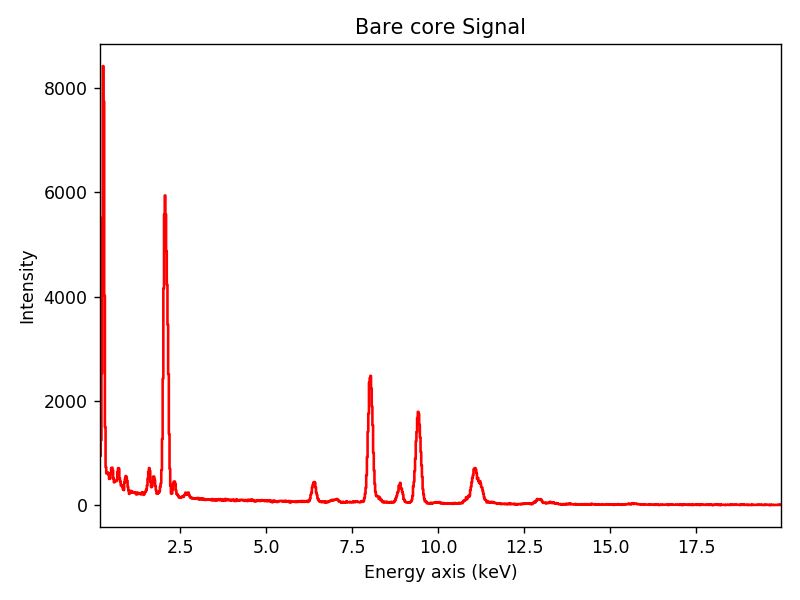

In [20]:
s_bare.plot()

## <a id='com'></a> 5. Comparison and quantification

<a href='#top'> Table of contents</a>

We stack together the spectrum of bare particles and the first ICA component:

In [21]:
s_bare.change_dtype('float')
s = hs.stack([s_bare, s_bss], new_axis_name='Bare or BSS')
s.metadata.General.title = 'Bare or BSS'

<IPython.core.display.Javascript object>


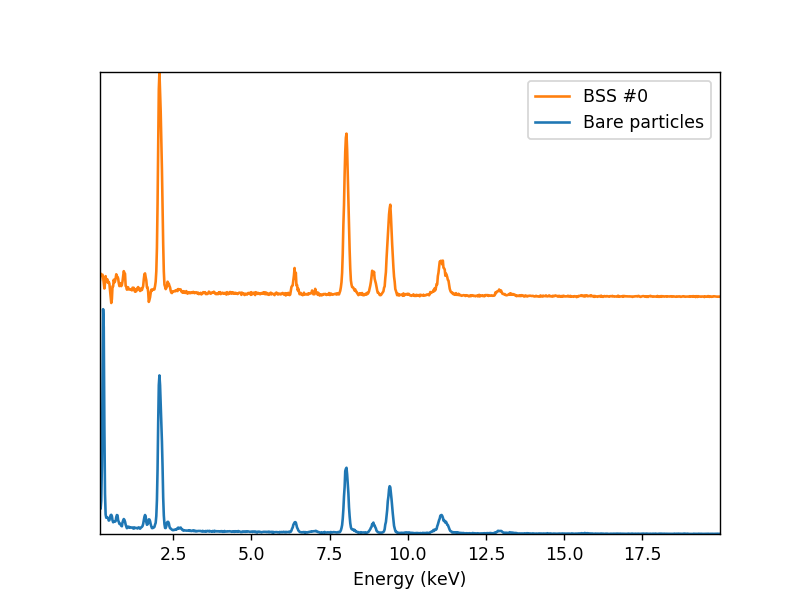

In [22]:
# Normalize the data for plotting for easier comparison:
axes = hs.plot.plot_spectra([sig/sig.data.max() for sig in s], style='cascade', 
                            legend=['Bare particles', 'BSS #0'])

### Comparison method 1 &mdash; net intensity calculation

X-ray intensities measurement with background subtraction

In [23]:
w = s.estimate_background_windows()

<IPython.core.display.Javascript object>


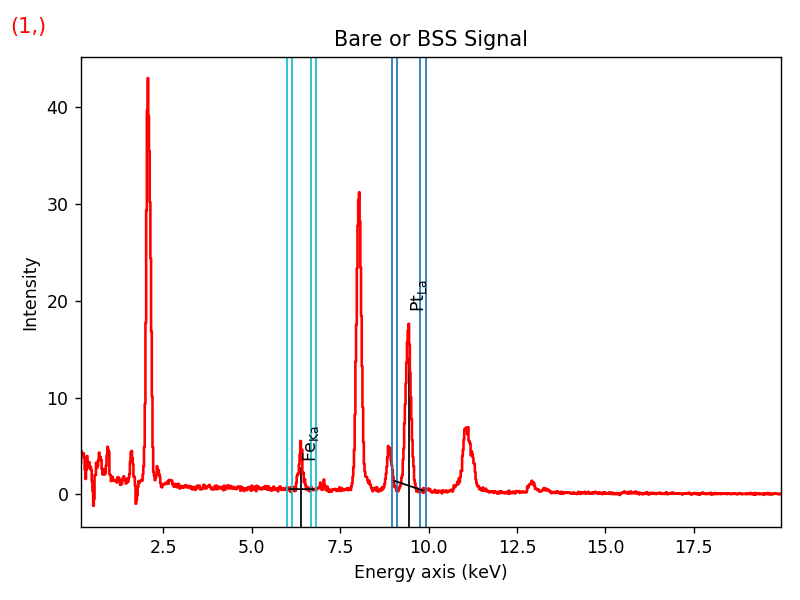

In [24]:
s.plot(background_windows=w, navigator='slider')

Refinement of the windows position.

In [25]:
w

array([[5.99958948, 6.13435965, 6.67344035, 6.80821052],
       [8.96061636, 9.1211109 , 9.7630891 , 9.92358364]])

In [26]:
w[1, 0] = 8.44
w[1, 1] = 8.65
w

array([[5.99958948, 6.13435965, 6.67344035, 6.80821052],
       [8.44      , 8.65      , 9.7630891 , 9.92358364]])

<IPython.core.display.Javascript object>


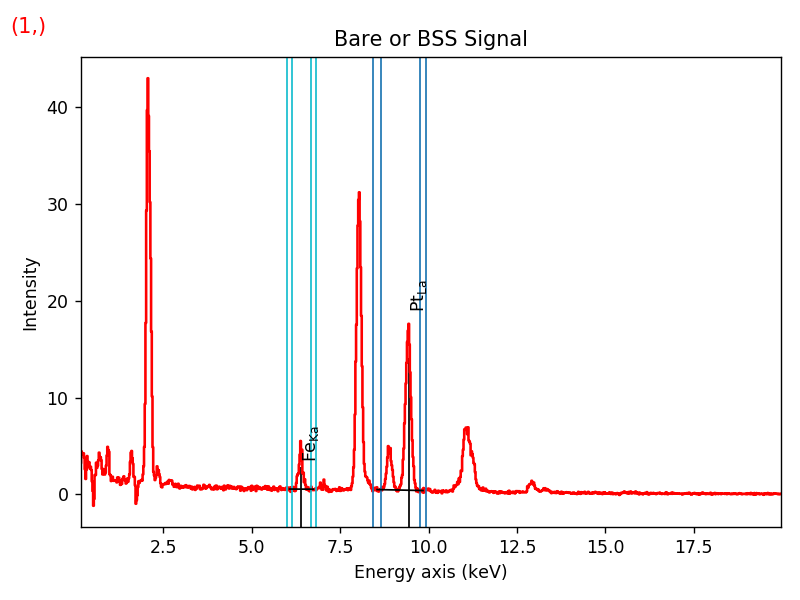

In [27]:
s.plot(background_windows=w, navigator='slider')

Get the net intensity under the peaks (using our new background windows):

In [28]:
sI = s.get_lines_intensity(background_windows=w)
sI

[<BaseSignal, title: X-ray line intensity of Bare or BSS: Fe_Ka at 6.40 keV, dimensions: (2|)>,
 <BaseSignal, title: X-ray line intensity of Bare or BSS: Pt_La at 9.44 keV, dimensions: (2|)>]

Comparing the ratio of Fe intensity to Pt:

In [29]:
print('Bare core Fe_Ka/Pt_La: \t{:.2f}'.format(sI[0].data[0] / sI[1].data[0]))
print('BSS Fe_Ka/Pt_La: \t{:.2f}'.format(sI[0].data[1] / sI[1].data[1]))

Bare core Fe_Ka/Pt_La: 	0.18
BSS Fe_Ka/Pt_La: 	0.19


### Comparison method 2 &mdash; model fitting

Measure X-ray intensity by fitting a Gaussian model

<IPython.core.display.Javascript object>


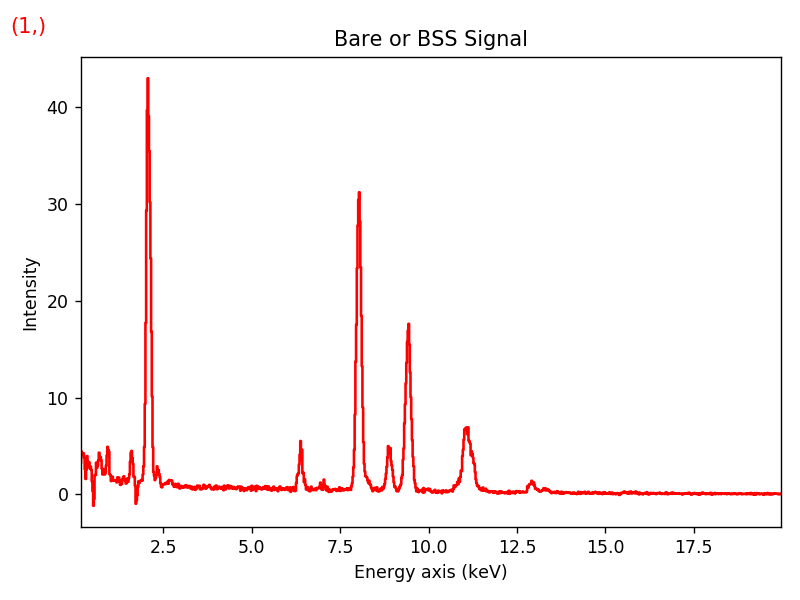

In [30]:
s.plot(navigator='slider')

In [32]:
# Create a model based off a cropped area of signal:
m = s.isig[5.:15.].create_model()

Add background copper and cobalt elements:

In [33]:
m.add_family_lines(['Cu_Ka', 'Co_Ka'])

Contents of the model:

In [34]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |  background_order_6 |  background_order_6 |          Polynomial
   1 |               Fe_Ka |               Fe_Ka |            Gaussian
   2 |               Fe_Kb |               Fe_Kb |            Gaussian
   3 |               Pt_La |               Pt_La |            Gaussian
   4 |              Pt_Lb1 |              Pt_Lb1 |            Gaussian
   5 |              Pt_Lb4 |              Pt_Lb4 |            Gaussian
   6 |               Pt_Ln |               Pt_Ln |            Gaussian
   7 |               Pt_Ll |               Pt_Ll |            Gaussian
   8 |              Pt_Lb2 |              Pt_Lb2 |            Gaussian
   9 |              Pt_Lb3 |              Pt_Lb3 |            Gaussian
  10 |              Pt_Lg3 |              Pt_Lg3 |            Gaussian
  11 |              Pt_Lg1 |              Pt_Lg1 |            Gaussian
  12 |

<IPython.core.display.Javascript object>


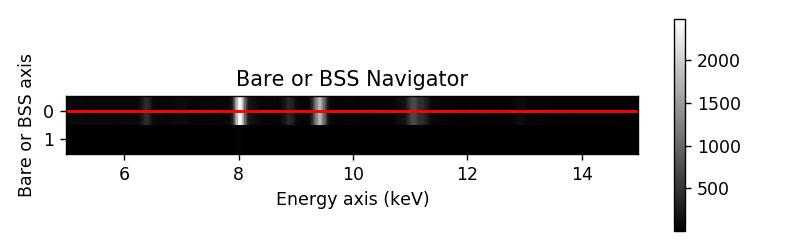

<IPython.core.display.Javascript object>


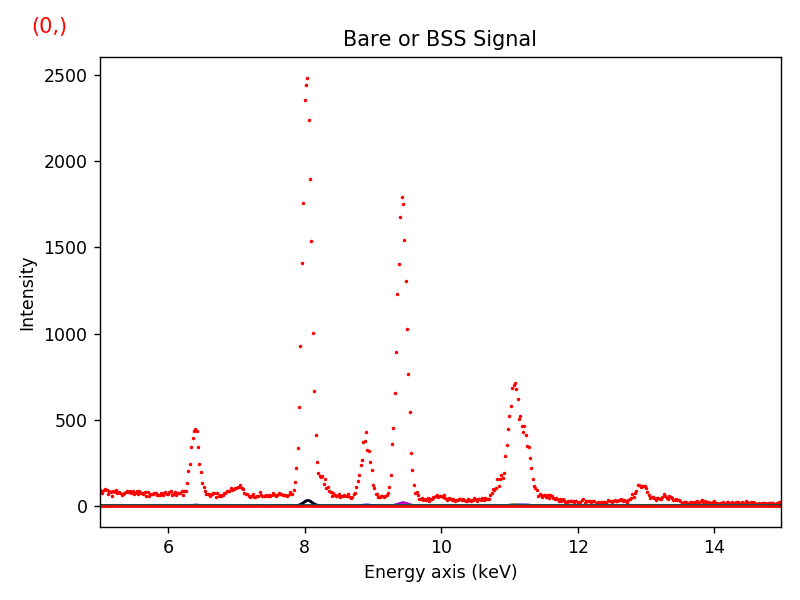

In [35]:
m.plot(plot_components=True)

Fitting the model at all locations of the signal is a simple one line command:

In [36]:
m.multifit(show_progressbar=False)

<IPython.core.display.Javascript object>


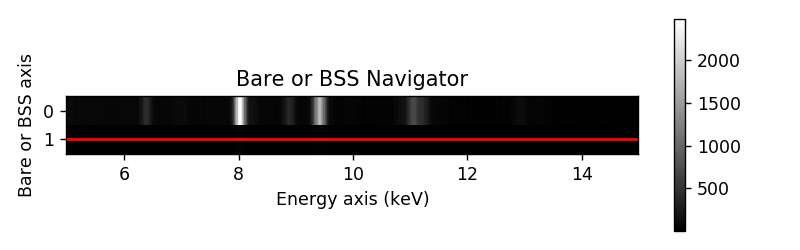

<IPython.core.display.Javascript object>


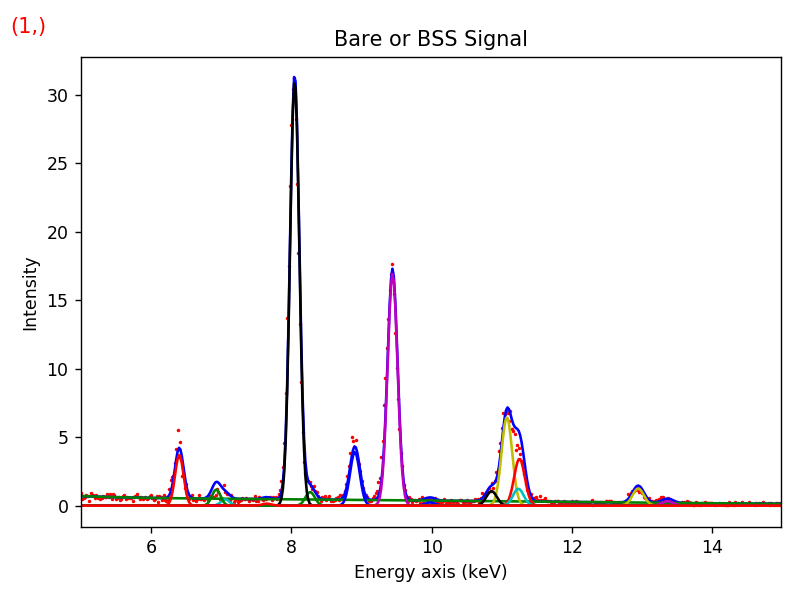

In [37]:
m.plot(plot_components=True)

The background is fitted separately:

In [38]:
m.fit_background()

In [39]:
m.calibrate_energy_axis()

<IPython.core.display.Javascript object>


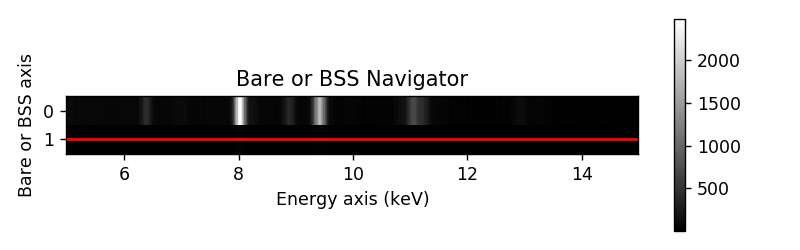

<IPython.core.display.Javascript object>


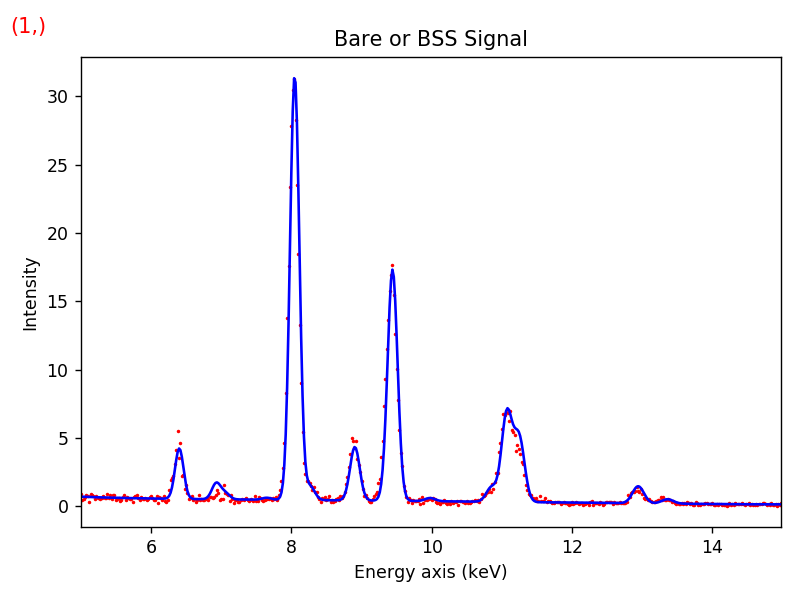

In [40]:
m.plot()

Finally, we probe line intensity from the fitted model:

In [41]:
sI = m.get_lines_intensity()[:2]
sI

[<BaseSignal, title: Intensity of Fe_Ka at 6.40 keV from Bare or BSS, dimensions: (2|)>,
 <BaseSignal, title: Intensity of Pt_La at 9.44 keV from Bare or BSS, dimensions: (2|)>]

Set up the kfactors for Fe K${\alpha}$ and Pt L${\alpha}$.

In [42]:
#From Bruker software (Esprit)
kfactors = [1.450226, 5.075602]

Quantify with Cliff Lorimer.

In [43]:
composition = s.quantification(method="CL", intensities=sI, factors=kfactors)

In [44]:
print('             |-----------------------------|')
print('             |     Atomic compositions     |')
print('             |-----------------------------|')

print(' \t     |  Bare core  |   BSS Signal  |')
print('|------------|-------------|---------------|')
print('| Fe (at. %) |    {:.2f}    |     {:.2f}     |'.format(composition[0].data[0], composition[0].data[1]))
print('| Pt (at. %) |    {:.2f}    |     {:.2f}     |'.format(composition[1].data[0], composition[1].data[1]))
print('|------------|-------------|---------------|')

             |-----------------------------|
             |     Atomic compositions     |
             |-----------------------------|
 	     |  Bare core  |   BSS Signal  |
|------------|-------------|---------------|
| Fe (at. %) |    16.02    |     15.66     |
| Pt (at. %) |    83.98    |     84.34     |
|------------|-------------|---------------|


## <a id='fur'></a> 6. Going further

<a href='#top'> Table of contents</a>

Further image processing with [scikit-image](http://scikit-image.org/) and [scipy](http://www.scipy.org/). Apply a watershed transformation to isolate the nanoparticles.

- Transform the mask into a distance map.
- Find local maxima.
- Apply the watershed to the distance map using the local maximum as seed (markers).

Adapted from this scikit-image [example](http://scikit-image.org/docs/dev/auto_examples/plot_watershed.html).

Import needed utilities from `scipy` and `skimage`:

In [45]:
from scipy.ndimage import distance_transform_edt, label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

Perform watershed segmentation:

In [46]:
distance = distance_transform_edt(mask.data)
local_maxi = peak_local_max(distance, indices=False,
                            min_distance=2, labels=mask.data)
labels = watershed(-distance, markers=label(local_maxi)[0],
                   mask=mask.data)

Plot the results:

<IPython.core.display.Javascript object>


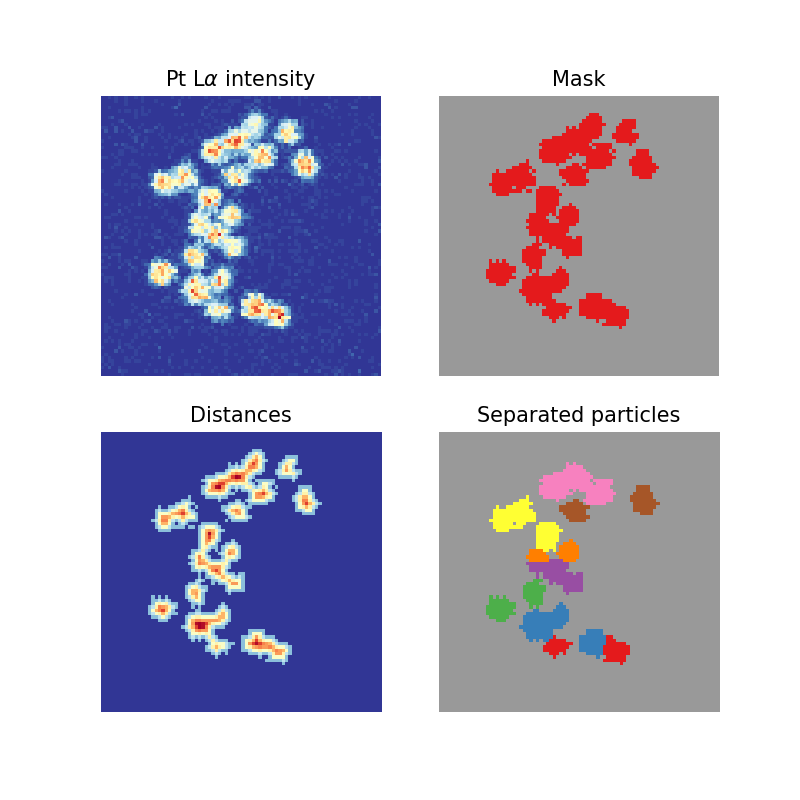

In [47]:
axes = hs.plot.plot_images(
    [pt_la.T, mask.T, hs.signals.Signal2D(distance), hs.signals.Signal2D(labels)],
    axes_decor='off', per_row=2, colorbar=None, cmap=['RdYlBu_r', 'Set1_r'],
    label=['Pt L${\\alpha}$ intensity', 'Mask',
           'Distances', 'Separated particles'])